# Dedalus script for 2D tracer adv-dif on a slope Analysis
## Ryan Holmes

In [185]:
# Load modules
import numpy as np
import h5py
import matplotlib
import shutil
import os
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from mpi4py import MPI
from scipy.special import erf
import time
from IPython import display

from dedalus import public as de
from dedalus.extras import flow_tools

from dedalus.tools import post
import pathlib
from dedalus.extras import plot_tools

## Post-process runs

In [160]:
# Merge snapshots from different processes:
# snapshots
post.merge_process_files("snapshots", cleanup=True)
set_paths = list(pathlib.Path("snapshots").glob("snapshots_s*.h5"))
post.merge_sets("snapshots/snapshots.h5", set_paths, cleanup=True)
# ifields
post.merge_process_files("ifields", cleanup=True)
set_paths = list(pathlib.Path("ifields").glob("ifields_s*.h5"))
post.merge_sets("ifields/ifields.h5", set_paths, cleanup=True)


2018-05-24 12:32:58,636 post 0/1 INFO :: Merging files from snapshots


2018-05-24 12:33:00,093 post 0/1 INFO :: Creating joint file snapshots/snapshots.h5


2018-05-24 12:33:01,249 post 0/1 INFO :: Merging files from ifields


2018-05-24 12:33:01,358 post 0/1 INFO :: Creating joint file ifields/ifields.h5


In [161]:
# Copy output files to new folder
outdir = 'saveRUNS/tmp/testrun/'

os.makedirs(outdir, exist_ok=True)
shutil.move('snapshots/snapshots.h5',outdir + 'snapshots.h5');
shutil.move('ifields/ifields.h5',outdir + 'ifields.h5');
shutil.move('runparams.npz',outdir + 'runparams.npz');

## Analyse runs

In [141]:
# display file contents
with h5py.File('saveRUNS/tmp/testrun/snapshots.h5', mode='r') as file:
    print(list(file['scales'].keys()))
    print(file['tasks/tr'])

['Tz', 'constant', 'iteration', 'ky', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'y', 'z']
<HDF5 dataset "tr": shape (50, 256, 128), type "<f8">


### Input fields

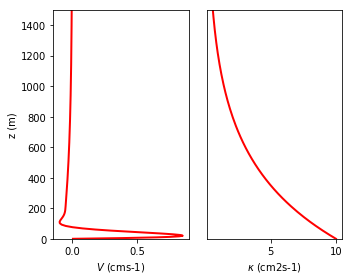

In [153]:
# Setup figure:
fig = plt.figure(figsize=(5, 4), facecolor='w')
axisV = plt.subplot(1,2,1)
axisV.set_xlabel('$V$ (cms-1)')
axisV.set_ylabel('z (m)')
axisV.set_ylim([0.,Lz])
axisK = plt.subplot(1,2,2)
axisK.set_xlabel('$\kappa$ (cm2s-1)')
axisK.set_ylim([0.,Lz])
axisK.axes.get_yaxis().set_ticks([])

runs = ['saveRUNS/tmp/testrun/'];
colors = ['r-','b-','g-','y-','m-'];

for ii in range(0,len(runs)):
    params = np.load(runs[ii] + 'runparams.npz');locals().update(params)
    with h5py.File(runs[ii] + 'ifields.h5', mode='r') as file:
        y = file['scales/y/1.0'][:];z = file['scales/z/1.0'][:];
        V = file['tasks/V'][0,0,:];K = file['tasks/K'][0,0,:];
        axisV.plot(V*100.0,z.T,colors[ii], linewidth=2.);
        axisK.plot((K)/1.0e-4,z.T,colors[ii], linewidth=2.);
plt.tight_layout()

In [ ]:
### Tracer Distribution

/home/z3500785/software/dedalus/dedalus/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


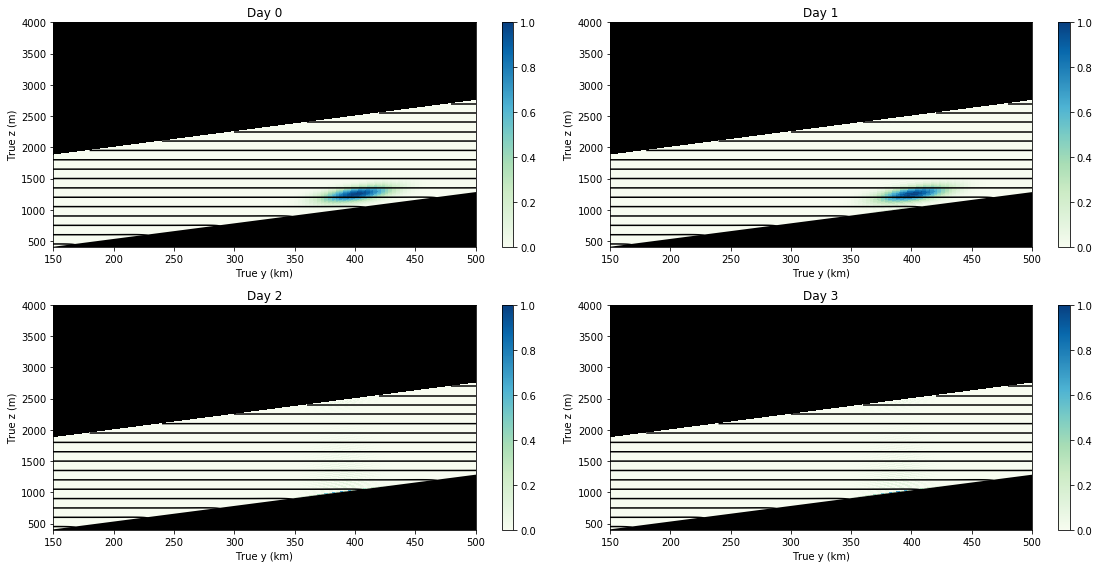

In [162]:
outdir = 'saveRUNS/tmp/testrun/'
params = np.load(outdir + 'runparams.npz');locals().update(params)
snaps = outdir + 'snapshots.h5';
fig = plt.figure(figsize=(16, 8), facecolor='w')
tts = [round(x) for x in np.linspace(0,3,4)]
for ii in range(len(tts)):#range(0,49):
    axisTR = plt.subplot(2,2,ii+1)
    axisTR.set_xlabel('True y (km)');axisTR.set_ylabel('True z (m)');axisTR.set_title('Tracer Concentration')
    axisTR.set_xlim([0,Ly/1.e3]);axisTR.set_ylim([0.,Lz + slope*Ly]);axisTR.set_facecolor('k')

    with h5py.File(snaps, mode='r') as file:
        y = file['scales/y/1.0'][:];z = file['scales/z/1.0'][:];
        dy = y[1:]-y[:-1];dz = z[1:]-z[:-1];
        dA = np.tile(dy,[len(z)-1,1]).T*np.tile(dz,[len(y)-1,1]);
        ym, zm = np.meshgrid(y,z)
        zt = np.cos(theta)*zm + np.sin(theta)*ym;
        yt = -np.sin(theta)*zm + np.cos(theta)*ym # Rotated Coordinates
        B = N2*np.sin(theta)*ym + N2*np.cos(theta)*(zm + np.exp(-q0*zm)*np.cos(q0*zm)/q0)
        t = file['scales/sim_time'][:]/lday;
        trT = file['tasks']['trT'][:,0,0]
        tr = file['tasks']['tr'][tts[ii],:,:]
        p = axisTR.pcolormesh(yt/1.e3, zt, tr.T/np.max(tr), cmap='GnBu', vmin=0., vmax=1.);#GnBu

    # Add buoyancy contours
    plt.contour(yt/1.0e3, zt, B, 30, colors='k')
    axisTR.plot(y/1.0e3, slope*y,'k-', linewidth=4.)
    plt.colorbar(p, ax = axisTR)
    plt.title('Day %d' % t[tts[ii]])
    ax = plt.gca()
    ax.set_ylim([400.,4000.])
    ax.set_xlim([150.,500.])

plt.tight_layout()
plt.savefig(outdir + 'TrConc_timeseries')    


### Buoyancy distribution and moments

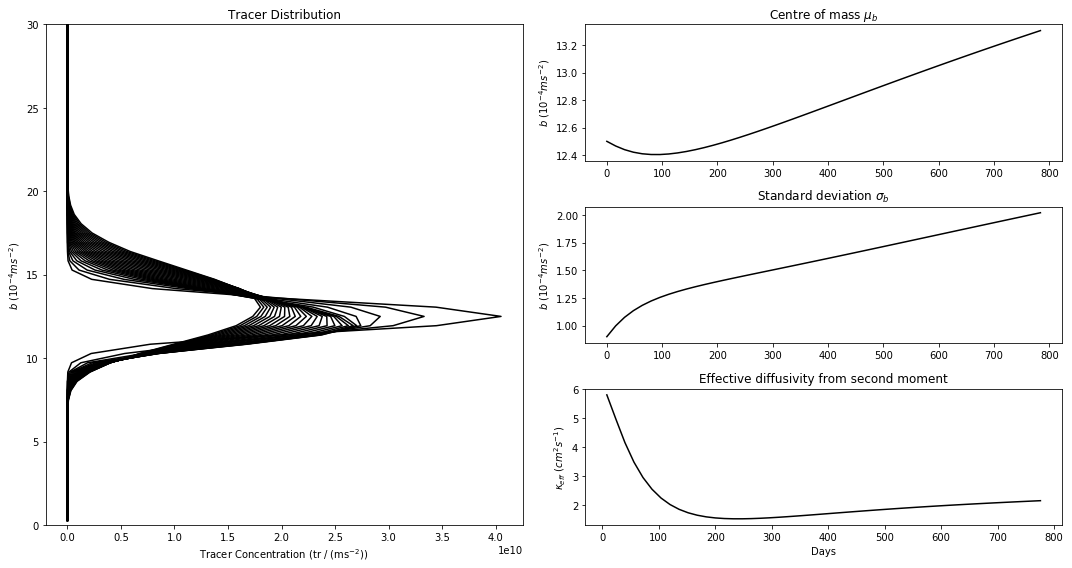

In [155]:
fig = plt.figure(figsize=(15, 8), facecolor='w')
ab0 = plt.subplot2grid((3,2),(0,0), colspan=1, rowspan=3)
ab1 = plt.subplot2grid((3,2),(0,1));
ab2 = plt.subplot2grid((3,2),(1,1));
ab3 = plt.subplot2grid((3,2),(2,1));
ab0.set_ylabel('$b\,\, (10^{-4} ms^{-2})$');ab0.set_xlabel('Tracer Concentration (tr / (ms$^{-2}$))');
ab0.set_title('Tracer Distribution')
ab0.set_ylim([0.,30.]);
ab1.set_ylabel('$b\,\, (10^{-4} ms^{-2})$');ab1.set_title('Centre of mass $\mu_b$');
ab2.set_ylabel('$b\,\, (10^{-4} ms^{-2})$');ab2.set_title('Standard deviation $\sigma_b$');
ab3.set_ylabel('$\kappa_{eff}\,\, (cm^2s^{-1})$');ab3.set_title('Effective diffusivity from second moment');
ab3.set_xlabel('Days')
eps = 0.1;

runs = ['saveRUNS/tmp/testrun/'];#["saveRUNS/Class1/z0_don5/snapshots.h5","saveRUNS/Class1/z0_don3/snapshots.h5","saveRUNS/Class1/z0_don2/snapshots.h5","saveRUNS/Class1/z0_don1/snapshots.h5"];
colors = ['k-','r-','b-','g-','y-','m-'];

for ii in range(0,len(runs)):

    params = np.load(runs[ii] + 'runparams.npz');locals().update(params)
    b = np.linspace(0,N2*np.cos(theta)*Lz + N2*np.sin(theta)*Ly,64);db = b[1]-b[0]
    ba = (b[:-1]+b[1:])/2

    with h5py.File(runs[ii] + 'ifields.h5', mode='r') as file:
        B = file['tasks']['B'][0,:,:]
        B = (B[1:,:] + B[:-1,:])/2
        B = (B[:,1:] + B[:,:-1])/2
        y = file['scales/y/1.0'][:];z = file['scales/z/1.0'][:];
    dy = y[1:]-y[:-1];dz = z[1:]-z[:-1];
    dA = np.tile(dy,[len(z)-1,1]).T*np.tile(dz,[len(y)-1,1]);

    with h5py.File(runs[ii] + 'snapshots.h5', mode='r') as file:

        t = file['scales/sim_time'][:]/lday;
        trT = file['tasks']['trT'][:,0,0]

        mub = np.zeros(len(t))
        sigma2b = np.zeros(len(t))
        for i in range(0,len(t),2):
            tr = file['tasks']['tr'][i,:,:]
            tr = (tr[1:,:] + tr[:-1,:])/2
            tr = (tr[:,1:] + tr[:,:-1])/2
            tr = tr*dA
            trC = [np.sum(tr[np.logical_and(B>=bi,B<(bi+db))])/db for bi in b[:-1]]
            ab0.plot(trC,(b[:-1]+b[1:])/2/1.e-4,colors[ii])
            
        bm1 = file['tasks']['bm1i'][:,0,0];
        bm2 = file['tasks']['bm2i'][:,0,0]
        mu = bm1/trT
        sigma2 = bm2/trT-(bm1/trT)**2.
        sigma2nomu = bm2/trT
        ab1.plot(t,mu/1.e-4,colors[ii])
        ab2.plot(t,np.sqrt(sigma2)/1.e-4,colors[ii])
        ab3.plot((t[1:]+t[:-1])/2,0.5*(sigma2[1:]-sigma2[:-1])/(t[1:]-t[:-1])/lday/N2/N2/1.e-4,colors[ii])
#        ab3.plot((t[1:]+t[:-1])/2,0.5*(sigma2nomu[1:]-sigma2nomu[:-1])/(t[1:]-t[:-1])/lday/N2/N2/1.e-4,colors[ii].replace('-','--'))

plt.tight_layout()
plt.savefig('bSpaceAnalysis');


### Z distribution and moments

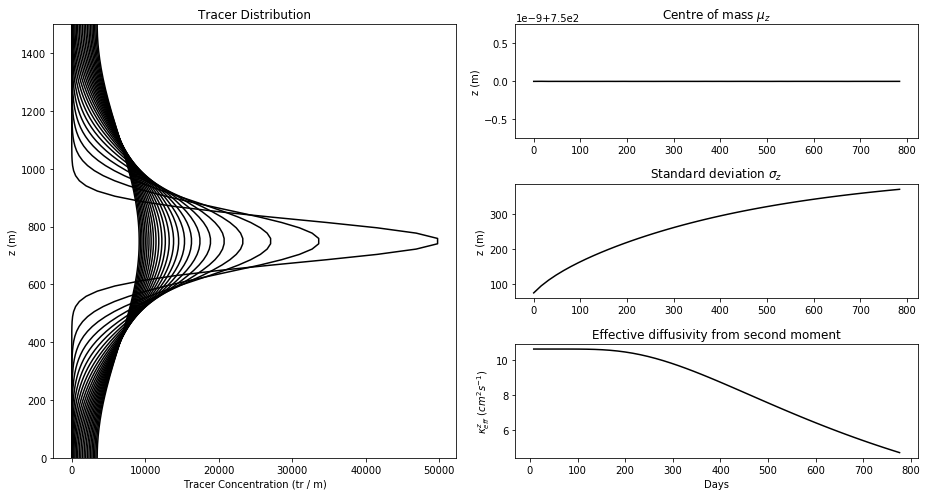

In [137]:
fig = plt.figure(figsize=(13, 7), facecolor='w')
ab0 = plt.subplot2grid((3,2),(0,0), colspan=1, rowspan=3)
ab1 = plt.subplot2grid((3,2),(0,1));
ab2 = plt.subplot2grid((3,2),(1,1));
ab3 = plt.subplot2grid((3,2),(2,1));
ab0.set_ylabel('z (m)');ab0.set_xlabel('Tracer Concentration (tr / m)');
ab0.set_title('Tracer Distribution');ab0.set_ylim([0.,Lz]);
ab1.set_ylabel('z (m)');ab1.set_title('Centre of mass $\mu_z$');
ab2.set_ylabel('z (m)');ab2.set_title('Standard deviation $\sigma_z$');
ab3.set_ylabel('$\kappa_{eff}^z\,\, (cm^2s^{-1})$');ab3.set_title('Effective diffusivity from second moment');
ab3.set_xlabel('Days')
eps = 0.1;

runs = ['saveRUNS/tmp/testrun/'];#["saveRUNS/Class1/z0_don5/snapshots.h5","saveRUNS/Class1/z0_don3/snapshots.h5","saveRUNS/Class1/z0_don2/snapshots.h5","saveRUNS/Class1/z0_don1/snapshots.h5"];
colors = ['k-','r-','b-','g-','y-','m-'];

for ii in range(0,len(runs)):

    params = np.load(runs[ii] + 'runparams.npz');locals().update(params)

    with h5py.File(runs[ii] + 'snapshots.h5', mode='r') as file:

        t = file['scales/sim_time'][:]/lday;
        ym0 = file['tasks']['ym0']

        for i in range(0,len(t),2):
            ab0.plot(ym0[i,0,:],z,colors[ii]);
    
        zm1 = file['tasks']['zm1i'][:,0,0];
        zm2 = file['tasks']['zm2i'][:,0,0]
        trT = file['tasks']['trT'][:,0,0]
        mu = zm1/trT
        sigma2 = zm2/trT-(zm1/trT)**2.
        ab1.plot(t,mu,colors[ii])
        ab2.plot(t,np.sqrt(sigma2),colors[ii])

        ab3.plot((t[1:]+t[:-1])/2,0.5*(sigma2[1:]-sigma2[:-1])/(t[1:]-t[:-1])/lday/1e-4,colors[ii])

plt.tight_layout()
plt.savefig('zSpaceAnalysis');

### Y Distribution and moments

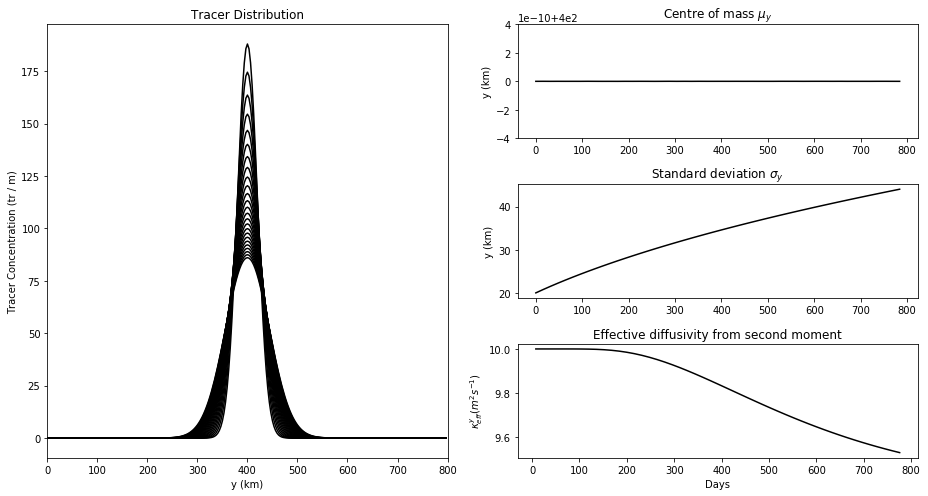

In [138]:
# Plot Y distribution and moments:
fig = plt.figure(figsize=(13, 7), facecolor='w')
ab0 = plt.subplot2grid((3,2),(0,0), colspan=1, rowspan=3)
ab1 = plt.subplot2grid((3,2),(0,1));
ab2 = plt.subplot2grid((3,2),(1,1));
ab3 = plt.subplot2grid((3,2),(2,1));
ab0.set_xlabel('y (km)');ab0.set_ylabel('Tracer Concentration (tr / m)');
ab0.set_title('Tracer Distribution');ab0.set_xlim([0.,Ly/1.e3]);
ab1.set_ylabel('y (km)');ab1.set_title('Centre of mass $\mu_y$');
ab2.set_ylabel('y (km)');ab2.set_title('Standard deviation $\sigma_y$');
ab3.set_ylabel('$\kappa^y_{eff} (m^2s^{-1})$');ab3.set_title('Effective diffusivity from second moment');
ab3.set_xlabel('Days')
eps = 0.1;

runs = ['saveRUNS/tmp/testrun/'];#["saveRUNS/Class1/z0_don5/snapshots.h5","saveRUNS/Class1/z0_don3/snapshots.h5","saveRUNS/Class1/z0_don2/snapshots.h5","saveRUNS/Class1/z0_don1/snapshots.h5"];
colors = ['k-','r-','b-','g-','y-','m-'];

for ii in range(0,len(runs)):

    params = np.load(runs[ii] + 'runparams.npz');locals().update(params)

    with h5py.File(runs[ii] + 'snapshots.h5', mode='r') as file:

        t = file['scales/sim_time'][:]/lday;
        zm0 = file['tasks']['zm0']

        for i in range(0,len(t),2):
            ab0.plot(y/1.e3,zm0[i,:,0],colors[ii]);
    
        ym1 = file['tasks']['ym1i'][:,0,0];
        ym2 = file['tasks']['ym2i'][:,0,0]
        trT = file['tasks']['trT'][:,0,0]
        mu = ym1/trT
        sigma2 = ym2/trT-(ym1/trT)**2.
        ab1.plot(t,mu/1.e3,colors[ii])
        ab2.plot(t,np.sqrt(sigma2)/1.e3,colors[ii])

        ab3.plot((t[1:]+t[:-1])/2,0.5*(sigma2[1:]-sigma2[:-1])/(t[1:]-t[:-1])/lday,colors[ii])
plt.tight_layout()
plt.savefig('ySpaceAnalysis');

In [ ]:
# Plot Y and Z moments on top of each other:
fig = plt.figure(figsize=(25, 10), facecolor='w')
ay0 = plt.subplot2grid((3,6),(0,0), rowspan=3);ay1 = plt.subplot2grid((3,6),(0,1), rowspan=3);ay2 = plt.subplot2grid((3,6),(0,2), rowspan=3)
ay0.set_ylabel('z (m)');ay0.set_title('< tr >^y');
ay1.set_title('< y tr >^y / < tr >^y');
ay2.set_title('< y^2 tr >^y / < tr >^y - (< y tr >^y / < tr >^y)^2');
eps = 0.1;

az0 = plt.subplot2grid((3,6),(0,3), colspan=3);az1 = plt.subplot2grid((3,6),(1,3), colspan=3);az2 = plt.subplot2grid((3,6),(2,3), colspan=3)
az2.set_xlabel('y (m)');az0.set_title('< tr >^z');
az1.set_title('< z tr >^z / < tr >^z');
az2.set_title('< z^2 tr >^z / < tr >^z - (< z tr >^z / < tr >^z)^2');

with h5py.File("snapshots/snapshots.h5", mode='r') as file:
    y = file['scales/y/1.0'][:];z = file['scales/z/1.0'][:]
    ym0 = file['tasks']['ym0'];ym1 = file['tasks']['ym1'];ym2 = file['tasks']['ym2']
    zm0 = file['tasks']['zm0'];zm1 = file['tasks']['zm1'];zm2 = file['tasks']['zm2']

    for i in range(len(ym0[:,0,0])):
        ay0.plot(ym0[i,0,:],z)
        ay1.plot(ym1[i,0,:]/np.maximum(ym0[i,0,:],eps)/1.e3,z)
        ay2.plot(np.sqrt(ym2[i,0,:]/np.maximum(ym0[i,0,:],eps)-(ym1[i,0,:]/np.maximum(ym0[i,0,:],eps))**2.)/1.0e3,z)

        az0.plot(y/1.e3,zm0[i,:,0])
        az1.plot(y/1.e3,zm1[i,:,0]/np.maximum(zm0[i,:,0],eps))
        az2.plot(y/1.e3,np.sqrt(zm2[i,:,0]/np.maximum(zm0[i,:,0],eps)-(zm1[i,:,0]/np.maximum(zm0[i,:,0],eps))**2.))
plt.savefig('YZMoments')

### Analytic plot of B derivatives to check BBL approximations for isopycnal mixing

/home/z3500785/software/dedalus/dedalus/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


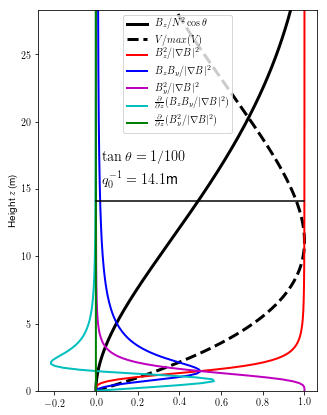

In [218]:
theta = np.arctan(1./100.);N2 = 1.e-6;K0 = 1.e-3;Pr0=1.
q0 = (N2*np.sin(theta)*np.sin(theta)/4.0/Pr0/K0/K0)**(1.0/4.0)

z = np.linspace(0.,2./q0,200.)
f  = np.exp(-q0*z)*(np.cos(q0*z)+np.sin(q0*z))
fz = -2.*q0*np.exp(-q0*z)*np.sin(q0*z)
V = -fz/np.tan(theta);
V = V/np.max(V)

Bz = 1-f
Bz2d = (1-f)**2./(np.tan(theta)**2.+(1-f)**2.)
ByBzd = (1-f)/(np.tan(theta)+(1./np.tan(theta))*(1-f)**2.)
By2d = 1/(1+(1./np.tan(theta))**2.*(1-f)**2.)
ByBzdd = fz*((1./np.tan(theta))*(1-f)**2.-np.tan(theta))/(np.tan(theta)+(1./np.tan(theta))*(1-f)**2.)**2.
By2dd = 2*(1-f)*fz/(1+(1./np.tan(theta))**2.*(1-f)**2.)**2.

fig = plt.figure(figsize=(5,7))
fig.set_facecolor('white')
plt.plot(Bz,z,'-k',linewidth=3,label=r'$B_z/N^2\cos{\theta}$')
plt.plot(V,z,'--k',linewidth=3,label=r'$V/max(V)$')
plt.plot(Bz2d,z,'-r',linewidth=2,label=r'$B_z^2/|\nabla B|^2$')
plt.plot(ByBzd,z,'-b',linewidth=2,label=r'$B_z B_y/|\nabla B|^2$')
plt.plot(By2d,z,'-m',linewidth=2,label=r'$B_y^2/|\nabla B|^2$')
plt.plot(ByBzdd,z,'-c',linewidth=2,label=r'$\frac{\partial}{\partial z}(B_z B_y/|\nabla B|^2)$')
plt.plot(By2dd,z,'-g',linewidth=2,label=r'$\frac{\partial}{\partial z}(B_y^2/|\nabla B|^2)$')
plt.plot([0.,1.],[1./q0,1./q0],'-k')
plt.legend()
ax = plt.gca()
ax.set_ylabel('Height $z$ (m)')
ax.set_ylim([0.,np.max(z)])
plt.text(0.03,1./q0+3,r'$\tan{\theta} = 1/%3.0f$' % (1./np.tan(theta)),fontsize='x-large')
plt.text(0.03,1./q0+1,r'$q_0^{-1} = %2.1f$m' % (1./q0),fontsize='x-large')
plt.savefig('IsopycnalMixing_Bgradients_Sl100.png')
